In [0]:
pip install awscli --force-reinstall --upgrade

Python interpreter will be restarted.
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Not uninstalling six at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-a9b3b40a-1082-4de8-b5d8-cd2978e17802
    Can't uninstall 'six'. No files were found to uninstall.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Not uninstalling urllib3 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-a9b3b40a-1082-4de8-b5d8-cd2978e17802
    Can't uninstall 'urllib3'. No files were found to uninstall.
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Not uninstalling python-dateutil at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-a9b3b40a-1082-4de8-b5d8-cd2978e17802
    Can't uninstall 'python-dateutil'. No 

In [0]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[3]") \
                            .appName('MyApplicationName') \
                            .getOrCreate()

import urllib.request
import boto3
import s3fs
import io
import os

access_key = ''
secret_key = ''
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
enconded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"

sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
bucket_name_trust = 'my-bigdata-project-sw/trusted/'
file_name_features = 'cleaned_amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv/'
file_path_features = 's3://' + bucket_name_trust + file_name_features
sdf = spark.read.parquet(file_path_features)


In [0]:
sdf.dtypes

Out[26]: [('product_id', 'string'),
 ('product_parent', 'int'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'int'),
 ('total_votes', 'int'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'date'),
 ('clean_review_headline', 'string'),
 ('clean_review_body', 'string'),
 ('clean_review_words', 'array<string>'),
 ('clean_review_filtered_words', 'array<string>'),
 ('clean_review_hash', 'vector'),
 ('clean_review_features', 'vector'),
 ('clean_headline_words', 'array<string>'),
 ('clean_headline_filtered_words', 'array<string>'),
 ('clean_headline_hash', 'vector'),
 ('clean_headline_features', 'vector'),
 ('sentiment_score_review', 'double'),
 ('product_id_i', 'double'),
 ('product_category_i', 'double'),
 ('verified_purchase_i', 'double'),
 ('product_id_v', 'vector'),
 ('product_category_v', 'vector'),
 ('star_rating_v', 'vector'),
 ('verified_purchase_v', 'vector'

In [0]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
import pyspark.sql.functions as func

sdf_train, sdf_test = sdf.randomSplit([0.80, 0.20], seed= 42)

In [0]:

#To predict star rating 
regression = LinearRegression(labelCol = 'star_rating')
#Fit to sdf training data
regression = regression.fit(sdf_train)
#Use on sdf test to predict
predictions = regression.transform(sdf_test)

In [0]:
predictions.select('star_rating','prediction').show(20)

+-----------+------------------+
|star_rating|        prediction|
+-----------+------------------+
|          3|3.6692622397331482|
|          5| 4.300825411909024|
|          1|3.4057805820284885|
|          5|  3.30835383367127|
|          1| 3.226383038684469|
|          5| 4.684372043307193|
|          3| 3.904072968979193|
|          5|4.8030737433210255|
|          4| 4.013188857646167|
|          4| 4.165884551486479|
|          5| 4.387462938530425|
|          5| 4.248604872158467|
|          1|4.1599333183696245|
|          5| 4.357325008469833|
|          5| 4.273663083129313|
|          5| 4.027317941458424|
|          5| 5.073624305817818|
|          5| 3.955743450661023|
|          2|3.8168939793429613|
+-----------+------------------+



RMSE: 0.0010565685798470663  R-squared:0.9999994487768157


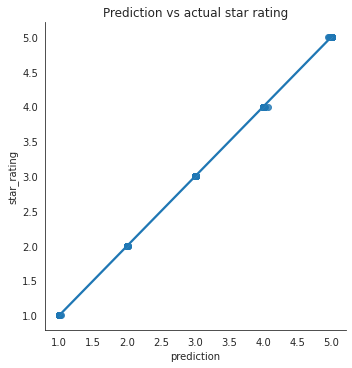

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


# Take the order total column and convert to a Pandas dataframe
df = predictions.select('star_rating', 'prediction').toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")
# Create the relationship plot
model1 = sns.lmplot(x='prediction', y='star_rating', data=df)
model1.set(title = 'Prediction vs actual star rating')

#Evaluate the above linear regression
# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='star_rating')

# Calculate RMSE and R2
rmse = evaluator.evaluate(predictions, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(predictions,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

In [0]:

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model1.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/Prediction_vs_actual_star_rating.png', 'wb') as f:
    f.write(img_data.getbuffer())

In [0]:
ridge_reg_star = LinearRegression(labelCol = 'star_rating', elasticNetParam = 0, regParam = 0.1) 
ridge_reg_star = ridge_reg_star.fit(sdf_train)
ridge_predictions_star = ridge_reg_star.transform(sdf_test)
ridge_predictions_star.select('star_rating','prediction').show()

+-----------+------------------+
|star_rating|        prediction|
+-----------+------------------+
|          5| 4.836253442365067|
|          1|1.1943005069005683|
|          5| 4.944761516154543|
|          2|2.0263761812541308|
|          3|2.9797095581166717|
|          4| 3.992570914465804|
|          5| 4.963544282103326|
|          3|3.0380339345139866|
|          1| 1.228850839139183|
|          1| 1.300194727513401|
|          3| 3.053183078149915|
|          4| 3.859919427343993|
|          5| 4.868548764134249|
|          1|0.9781721289608147|
|          2|2.1682531984185385|
|          3|3.1234522105881823|
|          5| 4.929209428426083|
|          5| 4.994476279395821|
|          2| 2.149252345873127|
|          4|3.9829766917370764|
+-----------+------------------+
only showing top 20 rows



RMSE: 0.1170027375791268  R-squared:0.9932403510975858


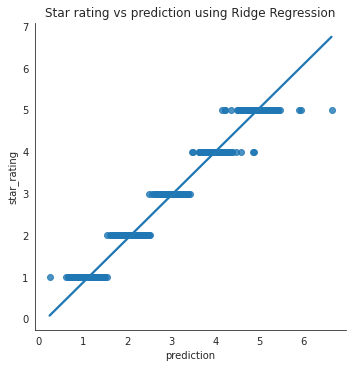

In [0]:

df = ridge_predictions_star.select('star_rating', 'prediction').toPandas() 
sns.set_style("white")
model2 = sns.lmplot(x='prediction', y='star_rating', data=df)
model2.set(title='Star rating vs prediction using Ridge Regression')

#regression eval
evaluator = RegressionEvaluator(labelCol = 'star_rating')
rmse = evaluator.evaluate(ridge_predictions_star, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(ridge_predictions_star,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# Create a buffer to hold the figure and save to S3
img_data = io.BytesIO()
model2.savefig(img_data, format='png', bbox_inches='tight')
img_data.seek(0)
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/Star_Rating_Model.png', 'wb') as f:
    f.write(img_data.getbuffer())


In [0]:
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model2.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/Prediction_vs_actual_star_rating_ridge_reg.png', 'wb') as f:
    f.write(img_data.getbuffer())

In [0]:
regression2.save("s3://my-bigdata-project-sw/models/Star_Rating_Model")

In [0]:
#To predict star rating 
regression2 = LinearRegression(labelCol = 'sentiment_score_review', elasticNetParam = 0, regParam = 0.1)
#Fit to sdf training data
regression2 = regression2.fit(sdf_train)
#Use on sdf test to predict
predictions_sentiment = regression2.transform(sdf_test)

In [0]:
predictions_sentiment.select('sentiment_score_review','prediction').show(50)

+----------------------+--------------------+
|sentiment_score_review|          prediction|
+----------------------+--------------------+
|               0.18375|  0.1837420985162547|
|                   0.0|3.389013271491566...|
|   0.31666666666666665| 0.31654764717293904|
|   0.19999999999999998| 0.20000428391917888|
|   0.03958333333333331|0.039602362807699076|
|   0.27499999999999997| 0.27499688837676983|
|   0.16675925925925927| 0.16671524285381698|
|   0.20166666666666666| 0.20171038722973542|
|   0.25833333333333336|  0.2581772212367943|
|  -0.09166666666666667|-0.09160409875502586|
|   0.22599206349206347| 0.22597517709127105|
|   0.18809523809523812| 0.18807386375724788|
|   0.19801882460973372|  0.1978317953953127|
|  0.005000000000000016|0.005023016221371198|
|    0.3538888888888889| 0.35392792512302795|
|   0.15535714285714286|  0.1553881643913729|
|   0.17753968253968255| 0.17738624957324728|
|                   0.7|  0.7000172055704628|
|    0.2380952380952381| 0.2381232

RMSE: 0.0001363007010691372  R-squared:0.9999997501907225


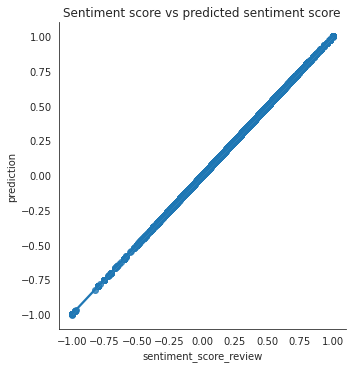

In [0]:
import seaborn as sns

#To predict star rating 
regression2 = LinearRegression(labelCol = 'sentiment_score_review', elasticNetParam = 0, regParam = 0.1)
#Fit to sdf training data
regression2 = regression2.fit(sdf_train)
#Use on sdf test to predict
predictions_sentiment = regression2.transform(sdf_test)

# Take the order total column and convert to a Pandas dataframe
df2 = predictions_sentiment.select('sentiment_score_review', 'prediction').toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")
# Create the relationship plot
model3 = sns.lmplot(x='sentiment_score_review', y='prediction', data=df2)
model3.set(title = 'Sentiment score vs predicted (Ridge Regression)')

#Evaluate the above linear regression
# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='sentiment_score_review')

# Calculate RMSE and R2
rmse = evaluator.evaluate(predictions_sentiment, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(predictions_sentiment,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model3.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/sentiment_score_model.png', 'wb') as f:
    f.write(img_data.getbuffer())


In [0]:
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model3.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/sentiment_score_model.png', 'wb') as f:
    f.write(img_data.getbuffer())

In [0]:
#Confusion matrix

predictions_sentiment.groupBy("sentiment_score_review",'prediction').count().show()

+----------------------+--------------------+-----+
|sentiment_score_review|          prediction|count|
+----------------------+--------------------+-----+
|   0.13333333333333333|    0.34949570683865|    1|
|                   0.3| 0.37355322938417784|    1|
|                  0.16| 0.23401258605753397|    1|
|    0.6424242424242425|  0.4706184309968658|    1|
|   0.14333333333333334|  0.2688705685638702|    1|
|                   0.7|  0.6547582631082403|    1|
|  -0.15555555555555559|  0.2277545019801896|    1|
|   0.10312500000000001|-0.06019109794107447|    1|
|   0.39285714285714285|  0.3916304726650674|    1|
|                   0.0|  0.5356776625016925|    1|
|   0.16375598086124404| 0.17229048448611137|    1|
|                   0.1| 0.18354996485559585|    1|
|    0.1654761904761905|  0.1187675428679538|    1|
|   0.20249999999999999|  0.3616123200285161|    1|
|  0.041071428571428585| 0.07929934292038471|    1|
|    0.4083333333333334| 0.48120927044695094|    1|
|    0.43333

In [0]:
regression2.save("s3://my-bigdata-project-sw/models/Sentiment_Score_Model")

In [0]:
#To predict star rating 
log_regression = LogisticRegression(labelCol = 'verified_purchase_i')
#Fit to sdf training data
log_regression = log_regression.fit(sdf_train)
#show model coeffficients and intercept
#print('Coefficient: ', log_regression.coefficients)
print('Intercept: ', log_regression.intercept)
#Use on sdf test to predict
log_predictions = log_regression.transform(sdf_test)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-3727281196295944>:4
      2 log_regression = LogisticRegression(labelCol = 'verified_purchase')
      3 #Fit to sdf training data
----> 4 log_regression = log_regression.fit(sdf_train)
      5 #show model coeffficients and intercept
      6 #print('Coefficient: ', log_regression.coefficients)
      7 print('Intercept: ', log_regression.intercept)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/spark/python/pyspark/ml/base.py:205, in Estimator.fit(self, dataset, params)
    203         return self.copy(params)._fit(dataset)
    204     el

RMSE: 0.5360710656809905  R-squared:-0.478113886328259


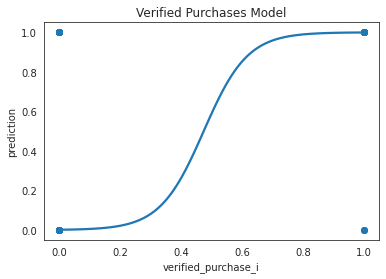

In [0]:

# Take the order total column and convert to a Pandas dataframe
df3 = log_predictions.select('verified_purchase_i', 'prediction').toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")
sns.set
# Create the relationship plot
#model1a = sns.lmplot(x='verified_purchase_i', y='prediction', data=df3)
model1a = sns.regplot(x='verified_purchase_i', y='prediction', data=df3, logistic=True, ci=None)
model1a.set(title = 'Verified Purchases Model')

#Evaluate the above linear regression
# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='verified_purchase_i')

# Calculate RMSE and R2
rmse = evaluator.evaluate(predictions_sentiment, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(predictions_sentiment,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model3.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/Helpful_votes_model.png', 'wb') as f:
    f.write(img_data.getbuffer())


In [0]:
regression2.save("s3://my-bigdata-project-sw/models/Sentiment_Score_Model")

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-2940394183217262>:1
----> 1 regression2.save("s3://my-bigdata-project-sw/models/Sentiment_Score_Model")

File /databricks/spark/python/pyspark/ml/util.py:340, in MLWritable.save(self, path)
    338 def save(self, path: str) -> None:
    339     """Save this ML instance to the given path, a shortcut of 'write().save(path)'."""
--> 340     self.write().save(path)

File /databricks/spark/python/pyspark/ml/util.py:291, in JavaMLWriter.save(self, path)
    289 if not isinstance(path, str):
    290     raise TypeError("path should be a string, got type %s" % type(path))
--> 291 self._jwrite.save(path)

File /databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py:1321, in JavaMember.__call__(self, *args)
   1315 command = proto.CALL_COMMAND_NAME +\
   1316     self.command_header +\
   1317     args_command +\
   

In [0]:
log_predictions.select('verified_purchase','verified_purchase_i', 'prediction').show()

# Show the confusion matrix
log_predictions.groupby('verified_purchase_i').pivot('prediction').count().sort('verified_purchase_i').show()
# The actual confusion matrix
confusion_matrix = log_predictions.groupby('verified_purchase_i').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(confusion_matrix):
    tn = confusion_matrix[0][1]  # True Negative
    fp = confusion_matrix[0][2]  # False Positive
    fn = confusion_matrix[1][1]  # False Negative
    tp = confusion_matrix[1][2]  # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(confusion_matrix) )



+-----------------+-------------------+----------+
|verified_purchase|verified_purchase_i|prediction|
+-----------------+-------------------+----------+
|                Y|                0.0|       0.0|
|                Y|                0.0|       0.0|
|                N|                1.0|       1.0|
|                Y|                0.0|       0.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                Y|                0.0|       0.0|
|                Y|                0.0|       0.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                N|                1.0|       1.0|
|                Y|                0.0|       0.0|
|                Y|                0.0|       0.0|
|                N|            

In [0]:
import io
import s3fs
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model2.savefig(img_data, format='png',bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/verified_purchase_regression.png', 'wb') as f:
    f.write(img_data.getbuffer())

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-816447112600945>:6
      4 img_data = io.BytesIO()
      5 # Write the figure to the buffer
----> 6 model2.savefig(img_data, format='png',bbox_inches='tight')
      7 # Rewind the pointer to the start of the data
      8 img_data.seek(0)

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [0]:
#DecisionTreeClassifier

tree = DecisionTreeClassifier(labelCol = 'star_rating')
tree_model = tree.fit(sdf_train)
predictions_tree = tree_model.transform(sdf_test)

In [0]:
predictions_tree.select('star_rating','prediction','probability').show(10)

+-----------+----------+--------------------+
|star_rating|prediction|         probability|
+-----------+----------+--------------------+
|          5|       5.0|[0.0,0.0,0.0,0.0,...|
|          1|       1.0|[0.0,1.0,0.0,0.0,...|
|          5|       5.0|[0.0,0.0,0.0,0.0,...|
|          2|       2.0|[0.0,0.0,1.0,0.0,...|
|          3|       3.0|[0.0,0.0,0.0,1.0,...|
|          4|       4.0|[0.0,0.0,0.0,0.0,...|
|          5|       5.0|[0.0,0.0,0.0,0.0,...|
|          3|       3.0|[0.0,0.0,0.0,1.0,...|
|          1|       1.0|[0.0,1.0,0.0,0.0,...|
|          1|       1.0|[0.0,1.0,0.0,0.0,...|
+-----------+----------+--------------------+
only showing top 10 rows



In [0]:
#To predict star rating 
Regression_helpful_votes = LinearRegression(labelCol = 'helpful_votes', elasticNetParam = 0, regParam = 0.1)
#Fit to sdf training data
Regression_review_body = Regression_helpful_votes.fit(sdf_train)
#Use on sdf test to predict
prediction_helpful_votes = Regression_review_body.transform(sdf_test)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1416403611736452>:4
      2 Regression_helpful_votes = LogisticRegression(labelCol = 'helpful_votes', elasticNetParam = 0, regParam = 0.1)
      3 #Fit to sdf training data
----> 4 Regression_review_body = Regression_helpful_votes.fit(sdf_train)
      5 #Use on sdf test to predict
      6 prediction_helpful_votes = Regression_review_body.transform(sdf_test)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/spark/python/pyspark/ml/base.py:205, in Estimator.fit(self, dataset, params)
    203         return self.copy(params)._fit(dataset)
   

RMSE: 23.221895431304898  R-squared:0.20904955820258242


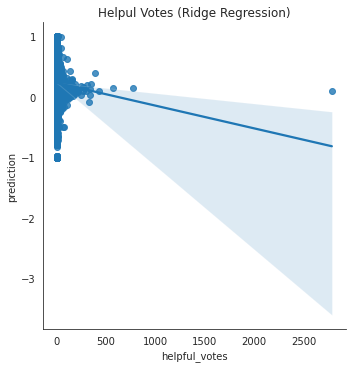

In [0]:

# Take the order total column and convert to a Pandas dataframe
df4 = predictions_sentiment.select('helpful_votes', 'prediction').toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")
# Create the relationship plot
model4 = sns.lmplot(x='helpful_votes', y='prediction', data=df4)
model4.set(title = 'Helpul Votes (Ridge Regression)')

#Evaluate the above linear regression
# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='helpful_votes')

# Calculate RMSE and R2
rmse = evaluator.evaluate(prediction_helpful_votes, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(prediction_helpful_votes,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model3.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/Helpful_votes_model_visualization.png', 'wb') as f:
    f.write(img_data.getbuffer())
regression2.save("s3://my-bigdata-project-sw/models/Helpful_votes_model")


In [0]:
evaluator = RegressionEvaluator(labelCol='sentiment_score_review')

# Calculate RMSE and R2
rmse = evaluator.evaluate(predictions_sentiment, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(predictions_sentiment,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
model3.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to the s3fs file system
s3 = s3fs.S3FileSystem(anon=False)
with s3.open('s3://my-bigdata-project-sw/models/sentiment_score_model.png', 'wb') as f:
    f.write(img_data.getbuffer())
